# Exercise Overview

This exercise guides you through the quality assurance and cleaning of a raw mobile phone data (MPD) dataset.

You will progress through three stages:
1. **Record-level syntactic checks:** basic format and completeness checks.
2. **Semantic checks:** consistency and behavior analysis to spot anomalies.
3. **Contextual filtering:** advanced rules to remove out-of-scope devices.

At each stage, you will:
- run pre-written code,
- interpret a quality report,
- complete a small exercise.

This notebook does not cover every aspect of QA and cleaning, but it provides a foundation for working with MPD datasets.

The exercise uses **synthetic data** from two files:

- **events.parquet** - event records
- **cells.csv** - cell tower information

# Preparation

Let's first load the necessary libraries.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Events data

Now import the raw events data.

In [2]:
events = pd.read_parquet('https://github.com/Flowminder/WB-GDF-Modern-Data-Workflows-Code-Tasks/raw/refs/heads/main/2.3.4_input_data/events.parquet')

Quick overview of the events data:

In [3]:
events.head(2)

,user_id,cell_id,timestamp
0,932,c00575,2025-03-01 00:00:00
1,76,c01473,2025-03-01 00:00:01


In [4]:
# Calculate total row count
total_rows_events = len(events)

# Calculate unique user ID count
unique_users_events = events['user_id'].nunique()

# Calculate unique cell ID count
unique_cells_ids_events = events['cell_id'].nunique()

# Find data period range
min_date_events = events['timestamp'].min()
max_date_events = events['timestamp'].max()

# Print the data overview summary
print("=" * 40)
print("Events data overview")
print("=" * 40)
print(f"1. Total row count:         {total_rows_events:,}")
print(f"2. Unique user IDs:         {unique_users_events:,}")
print(f"3. Unique cell IDs:         {unique_cells_ids_events:,}")
print(f"4. Date range (min):        {min_date_events}")
print(f"5. Date range (max):        {max_date_events}")
print("=" * 40)

Events data overview
1. Total row count:         4,282,643
2. Unique user IDs:         1,050
3. Unique cell IDs:         4,407
4. Date range (min):        2025-03-01 00:00:00
5. Date range (max):        2025-03-31 04:32:11


## Cells data

Next, import the cells data.

In [5]:
cells = pd.read_csv('https://raw.githubusercontent.com/Flowminder/WB-GDF-Modern-Data-Workflows-Code-Tasks/refs/heads/main/2.3.4_input_data/cells.csv')

Quick overview of the cells data:

In [6]:
display(cells.head(2))

,cell_id,longitude,latitude
0,c00000,-46.9922,-22.8207
1,c00001,-46.9298,-23.8346


In [7]:
# Calculate total row count
total_rows_cells = len(cells)

# Calculate unique cell ID count
unique_cells_ids_cells = cells['cell_id'].nunique()

# Calculate unique location count
unique_cell_locations = cells[['latitude', 'longitude']].drop_duplicates().shape[0]

# Print the overview summary
print("=" * 40)
print("Cells data overview")
print("=" * 40)
print(f"1. Total row count:         {total_rows_cells:,}")
print(f"2. Unique cell IDs:         {unique_cells_ids_cells:,}")
print(f"3. Unique locations:        {unique_cell_locations:,}")
print("=" * 40)

Cells data overview
1. Total row count:         5,000
2. Unique cell IDs:         5,000
3. Unique locations:        4,913


Let's also look at the cells data on a map.

In [8]:
# Visualize cell locations on a map
fig = px.scatter_map(
    cells, # dataframe containing cell locations
    lat="latitude", # latitude column
    lon="longitude", # longitude column
    hover_name="cell_id", # column to display on hover
    zoom=8, # initial zoom level
    height=600, # height of the map
    width=800, # width of the map
    title="Cell locations" # title of the map
)

fig.update_layout(mapbox_style="open-street-map") # use OpenStreetMap style
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0}) # adjust margins
fig.show()

# 1: Record-level syntactic checks

We will begin with syntactic data quality checks, starting with the events data.

The objective is to identify and clean records with syntactic errors. In this notebook, we focus on issues such as missing values and duplicates.

Indicators to be calculated:
- **Duplicate row count** - total number of duplicate records.

- **Invalid row count and invalid value count** - number of records and number of missing values in key columns.

## Duplicate row count check

Define key columns:

In [9]:
user_id_col = 'user_id'
cell_id_col = 'cell_id'
timestamp_col = 'timestamp'

We'll start with duplicate rows.
Create a function for checking and removing duplicate rows:

In [10]:
def drop_and_count_duplicates(events_df, columns_to_check=[]):
    deduplicated_df = events_df[columns_to_check].drop_duplicates() # Remove duplicate rows based on specified columns
    duplicate_count = len(events_df) - len(deduplicated_df) # Count of duplicate rows removed
    return deduplicated_df, {"total_rows": len(events_df), "duplicate_rows": duplicate_count} # Return deduplicated DataFrame and stats

Apply the drop-duplicates function to the original events DataFrame:

In [11]:
events_deduped, events_duplicate_stats = drop_and_count_duplicates(events,columns_to_check=[user_id_col, cell_id_col, timestamp_col])

Define threshold values for acceptable percentages of duplicates:

In [12]:
duplicate_rows_threshold = 0.05  # Define a threshold for acceptable duplicate rows percentage, e.g., 0.05 for 5%

Create a function that takes the duplicate-row statistics and a threshold value as input and generates a quality report:

In [13]:
def quality_report(err_stats, threshold):
    print("=" * 90)
    print("DATA QUALITY REPORT")
    print("=" * 90)

    # Create table header
    print(f"{'INDICATOR':<25} {'TOTAL_ROWS':<12} {'ERR_ROWS':<10} {'THRESHOLD':<12} {'ERR %':<10} {'STATUS':<8}")
    print("-" * 90)

    total_rows = err_stats['total_rows']
    passed_checks = 0
    total_checks = 0

    # Loop through all keys except 'total_rows'
    for key, value in err_stats.items():
        if key == 'total_rows':
            continue

        # Format indicator name (remove underscores, capitalize)
        indicator_name = key.replace('_', ' ').title()

        err_percentage = (value / total_rows) * 100
        status = "PASS" if err_percentage <= threshold * 100 else "FAIL"

        if status == "PASS":
            passed_checks += 1
        total_checks += 1

        print(f"{indicator_name:<25} {total_rows:<12} {value:<10} {threshold*100:.1f}%{'':<7} {err_percentage:.2f}%{'':<5} {status:<8}")

    print("-" * 90)
    print(f"SUMMARY: {passed_checks}/{total_checks} checks PASSED, {total_checks - passed_checks}/{total_checks} checks FAILED")


Generate the quality report for duplicate rows:

In [14]:
# Generate and display the quality report for duplicate rows
quality_report(events_duplicate_stats, duplicate_rows_threshold)

DATA QUALITY REPORT
INDICATOR                 TOTAL_ROWS   ERR_ROWS   THRESHOLD    ERR %      STATUS  
------------------------------------------------------------------------------------------
Duplicate Rows            4282643      82860      5.0%        1.93%      PASS    
------------------------------------------------------------------------------------------
SUMMARY: 1/1 checks PASSED, 0/1 checks FAILED


## Missing values check

Now that we've removed duplicate rows, we can create a function to check for missing values in key columns:

In [15]:
def drop_and_count_missing_values(df, required_columns=[]):
    # Initialize overall missing values mask
    missing_values_mask = pd.Series(False, index=df.index)

    # Dictionary to store individual column statistics
    column_stats = {}

    # Loop through each required column
    for column in required_columns:
        # Check for missing values in this column
        column_missing_mask = df[column].isnull()

        # Add to overall missing values mask
        missing_values_mask = missing_values_mask | column_missing_mask

        # Store individual column statistics
        column_stats[f"missing_{column}"] = column_missing_mask.sum()

    # Create cleaned DataFrame
    cleaned_df = df[~missing_values_mask]

    # Create DataFrame with rows where some values were missing (for inspection if needed)
    missing_rows_df = df[missing_values_mask]

    # Create comprehensive statistics dictionary
    stats = {
        "total_rows": len(df),
        "missing_rows_total": missing_values_mask.sum(),
        **column_stats  # Unpack individual column statistics
    }

    return cleaned_df, missing_rows_df, stats # return cleaned DataFrame, missing rows DataFrame, and stats as dictionary

Now that we've defined the function, apply it to our deduplicated events data:

In [16]:
events_cleaned, events_missing_values, events_missing_values_stats = drop_and_count_missing_values(events_deduped, required_columns=[user_id_col, cell_id_col, timestamp_col])

You can also inspect the events with missing values:

In [17]:
events_missing_values.head()

,user_id,cell_id,timestamp
1560,None,None,2025-03-01 00:17:55
3409,775,None,2025-03-01 00:40:00
4930,None,None,2025-03-01 00:58:19
5975,706,None,2025-03-01 01:10:27
7046,None,None,2025-03-01 01:23:21


Define threshold values for acceptable percentages of missing values:

In [18]:
missing_values_threshold = 0.05  # Define a threshold for acceptable missing values percentage, e.g., 0.05 for 5%

Also, generate the quality report for missing values. We can reuse the reporting function we used for duplicate rows:

In [19]:
quality_report(events_missing_values_stats, missing_values_threshold)

DATA QUALITY REPORT
INDICATOR                 TOTAL_ROWS   ERR_ROWS   THRESHOLD    ERR %      STATUS  
------------------------------------------------------------------------------------------
Missing Rows Total        4199783      3376       5.0%        0.08%      PASS    
Missing User Id           4199783      1958       5.0%        0.05%      PASS    
Missing Cell Id           4199783      3376       5.0%        0.08%      PASS    
Missing Timestamp         4199783      0          5.0%        0.00%      PASS    
------------------------------------------------------------------------------------------
SUMMARY: 4/4 checks PASSED, 0/4 checks FAILED


## Exercise 1


Perform the same syntactic quality checks on the cells data (duplicate rows, missing values). Generate a quality report for the cells data using the same approach as for the events data. Reuse the functions defined earlier in the notebook.

In [20]:
# First use drop_and_count_duplicates function
# ..._deduped, ..._duplicate_stats = drop_and_count_duplicates(..., columns_to_check=[...])

In [21]:
# Now generate quality report
# quality_report(..._duplicate_stats, duplicate_rows_threshold)

In [22]:
# Now use drop_and_count_missing_values function on cells data
# ..._cleaned, ..._missing_values, ..._missing_values_stats = drop_and_count_missing_values(..., required_columns=[...])

In [23]:
# And finally generate quality report for missing values in cells data
# quality_report(..._missing_values_stats, missing_values_threshold)

# 2: Semantic checks


This stage focuses on logical consistency and meaning.

Objective: analyze the data for logical errors and behavioral anomalies across time and space.

We'll look at:

- **Daily event count** - a time-series showing the number of events per day.
- **Event and unique users share by cell** - a map of events and unique users across cells.

As input for this stage, we'll use the cleaned data from the previous step.

## Daily event count

First lets create a function to calculate daily event count:

In [24]:
def event_count_per_day(events_df, timestamp_col):
    # Convert timestamp column to datetime with mixed format handling
    events_df = events_df.copy()  # Create a copy to avoid modifying the original
    events_df['date'] = pd.to_datetime(events_df[timestamp_col], format='mixed', errors='coerce').dt.date # Extract date part

    # Count records per day
    daily_stats = events_df.groupby('date').size().reset_index(name='event_count')

    return daily_stats # Return DataFrame with date and event count

Now use this function to calculate the daily event count for the cleaned events data:

In [25]:
daily_event_stats = event_count_per_day(events_cleaned, timestamp_col)

Let's look at the results:

In [26]:
display(daily_event_stats)

,date,event_count
0,2025-03-01,127568
1,2025-03-02,127908
2,2025-03-03,145246
3,2025-03-04,146797
4,2025-03-05,146221
5,2025-03-06,146275
6,2025-03-07,145072
7,2025-03-08,128267
8,2025-03-09,127853
9,2025-03-10,146215


Visualize the daily record count using a time-series plot:

In [27]:
plot_fig = px.line(
    daily_event_stats,
    x='date',
    y='event_count',
    title='Daily event count',
    labels={'date': 'Date', 'event_count': 'Event count'}
)
plot_fig.show()

The plot shows a logical pattern: peaks on weekdays and drops on weekends. A decline at the end of the month is expected because it coincides with the end of the data collection period.

Although visual checks are useful, defining thresholds helps identify anomalies systematically. Our dataset is small here, but in real‑world scenarios with larger data, automated checks are essential.

As in the previous stage, define a threshold - this time for acceptable variation in daily event counts (standard deviations):

In [28]:
daily_event_count_std_threshold=2.0  # Define a threshold for acceptable daily event count standard deviation, e.g., 2.0 for 2 standard deviations

Create a function to generate a quality report for daily event counts using the threshold defined above:

In [29]:
def detect_daily_anomalies(daily_stats_df, count_column='event_count', std_threshold=2.0):
    """
    Detect unusual peaks and drops in daily event counts using statistical thresholds.

    Args:
        daily_stats_df: DataFrame with daily statistics
        count_column: column name containing the daily counts
        std_threshold: number of standard deviations to use as threshold (default: 2.0)

    Returns:
        DataFrame with anomaly detection results
    """

    # Calculate period statistics
    period_mean = daily_stats_df[count_column].mean()
    period_std = daily_stats_df[count_column].std()

    # Calculate thresholds
    upper_threshold = period_mean + (std_threshold * period_std)
    lower_threshold = period_mean - (std_threshold * period_std)

    # Create analysis DataFrame
    anomaly_results = daily_stats_df.copy()

    # Calculate z-scores (how many standard deviations from mean)
    anomaly_results['z_score'] = (anomaly_results[count_column] - period_mean) / period_std

    # Identify anomalies
    anomaly_results['is_peak'] = anomaly_results[count_column] > upper_threshold
    anomaly_results['is_drop'] = anomaly_results[count_column] < lower_threshold
    anomaly_results['is_anomaly'] = anomaly_results['is_peak'] | anomaly_results['is_drop']

    # Add deviation information
    anomaly_results['deviation_from_mean'] = anomaly_results[count_column] - period_mean
    anomaly_results['deviation_percentage'] = (anomaly_results['deviation_from_mean'] / period_mean) * 100

    # Print summary statistics
    print("=" * 60)
    print("DAILY EVENTS ANOMALY DETECTION REPORT")
    print("=" * 60)
    print(f"Period average:           {period_mean:.1f} events/day")
    print(f"Period std deviation:     {period_std:.1f}")
    print(f"Threshold (±{std_threshold} std):       {lower_threshold:.1f} - {upper_threshold:.1f}")
    print(f"Total days analyzed:      {len(anomaly_results)}")
    print(f"Anomalous days found:     {anomaly_results['is_anomaly'].sum()}")
    print(f"  - Unusual peaks:        {anomaly_results['is_peak'].sum()}")
    print(f"  - Unusual drops:        {anomaly_results['is_drop'].sum()}")
    print("=" * 60)

    # Show anomalous days if any
    anomalous_days = anomaly_results[anomaly_results['is_anomaly']]
    if len(anomalous_days) > 0:
        print("\nANOMALOUS DAYS DETECTED:")
        print("-" * 40)
        for _, row in anomalous_days.iterrows():
            anomaly_type = "PEAK" if row['is_peak'] else "DROP"
            print(f"{row['date']}: {row[count_column]:,} events ({anomaly_type}, {row['deviation_percentage']:+.1f}% from avg, z={row['z_score']:+.1f})")
    else:
        print("\n✅ No significant anomalies detected in the data.")

    return anomaly_results

In [30]:
# Apply anomaly detection to daily events data
daily_anomaly_results = detect_daily_anomalies(
    daily_event_stats,
    count_column='event_count',
    std_threshold=daily_event_count_std_threshold  # Use the threshold variable defined above
)

DAILY EVENTS ANOMALY DETECTION REPORT
Period average:           135368.0 events/day
Period std deviation:     26410.5
Threshold (±2.0 std):       82546.9 - 188189.0
Total days analyzed:      31
Anomalous days found:     1
  - Unusual peaks:        0
  - Unusual drops:        1

ANOMALOUS DAYS DETECTED:
----------------------------------------
2025-03-31: 487 events (DROP, -99.6% from avg, z=-5.1)


For better understanding, let's visualize daily events with anomaly detection:

In [31]:
fig = go.Figure()

# Add main time series
fig.add_trace(go.Scatter(
    x=daily_anomaly_results['date'],
    y=daily_anomaly_results['event_count'],
    mode='lines+markers',
    name='Daily Events',
    line=dict(color='blue', width=2),
    marker=dict(size=4)
))

# Add anomaly markers
anomalous_days = daily_anomaly_results[daily_anomaly_results['is_anomaly']]
if len(anomalous_days) > 0:
    # Peaks
    peaks = anomalous_days[anomalous_days['is_peak']]
    if len(peaks) > 0:
        fig.add_trace(go.Scatter(
            x=peaks['date'],
            y=peaks['event_count'],
            mode='markers',
            name='Unusual Peaks',
            marker=dict(color='red', size=10, symbol='triangle-up')
        ))

    # Drops
    drops = anomalous_days[anomalous_days['is_drop']]
    if len(drops) > 0:
        fig.add_trace(go.Scatter(
            x=drops['date'],
            y=drops['event_count'],
            mode='markers',
            name='Unusual Drops',
            marker=dict(color='orange', size=10, symbol='triangle-down')
        ))

# Add threshold lines
period_mean = daily_anomaly_results['event_count'].mean()
period_std = daily_anomaly_results['event_count'].std()
upper_threshold = period_mean + (daily_event_count_std_threshold * period_std)
lower_threshold = period_mean - (daily_event_count_std_threshold * period_std)

fig.add_hline(y=period_mean, line_dash="dash", line_color="green",
              annotation_text="Period Average", annotation_position="top right")
fig.add_hline(y=upper_threshold, line_dash="dot", line_color="red",
              annotation_text=f"Upper Threshold (+{daily_event_count_std_threshold}σ)", annotation_position="top right")
fig.add_hline(y=lower_threshold, line_dash="dot", line_color="orange",
              annotation_text=f"Lower Threshold (-{daily_event_count_std_threshold}σ)", annotation_position="bottom right")

fig.update_layout(
    title='Daily event count with anomaly detection',
    xaxis_title='Date',
    yaxis_title='Event Count',
    hovermode='x unified',
    showlegend=True
)

fig.show()

As noted, the drop on the final date is acceptable because it marks the end of the data period.

## Event share in cells

As a next step, examine the distribution of events and unique users across cells on a map. First compute event and unique‑user counts per cell. A bubble map is a clear way to visualize this.

In [32]:
# First aggregate events_cleaned by cell_id to get event counts
cell_event_aggregation = events_cleaned.groupby('cell_id').agg({
    'user_id': ['count', 'nunique']
}).reset_index()

# Flatten column names
cell_event_aggregation.columns = ['cell_id', 'total_events', 'unique_users']

# Now left join with cells data to add location information
cell_activity_map = pd.merge(cell_event_aggregation, cells, on='cell_id', how='left')

In [33]:
# Create bubble map visualization using the aggregated cell activity data
fig_bubble = px.scatter_map(
    cell_activity_map,
    lat="latitude",
    lon="longitude",
    size="total_events",          # Size proportional to total event count
    color="unique_users",         # Color based on unique user count
    hover_name="cell_id",         # Show cell_id on hover
    hover_data={
        "total_events": True,
        "unique_users": True,
        "latitude": False,
        "longitude": False
    }, # Clean up hover data
    color_continuous_scale=px.colors.sequential.Plasma, # Color scale
    size_max=40,                  # Control max bubble size
    zoom=8,
    height=600,
    title="Cell activity - event and users distribution"
)

fig_bubble.update_layout(mapbox_style="open-street-map")
fig_bubble.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_bubble.show()

## Exercise 2

Analyze the geographical distribution of events and users on the map and answer these questions:

1. **Urban vs rural distribution**: is activity logically distributed between urban and rural areas?

2. **Data quality issues**: what potential issues might you suspect if you see very large bubbles in remote/rural areas or very small bubbles in city centers?

# 3: Contextual data filtering

This final stage applies contextual rules to filter out out-of-scope devices.

Objective: build and apply filters to remove non‑human or irrelevant records (e.g., IoT devices, fast flyers, ships) based on behavioral patterns.

**In this notebook we will be trying to detect IoT devices.**

## IoT device filtering

**Example IoT device**

Consider device `IOT_DEVICE_0001` — a temperature sensor in a warehouse:
- Location: always reports from cell_id `CELL_4547` (warehouse location)
- Timing pattern: reports every 60 minutes with 95% regularity
- Sample timeline: 09:00 → 10:01 → 11:00 → 12:02 → 13:00 → 14:01 …
- Detection criteria met:
  - Static: 1 unique location (stays in warehouse)
  - Regular: 95% of intervals ~60 minutes (exceeds threshold)

**Contrast with human user `USER_12345`**
- Location: visits 15 different cells (home, work, shops, etc.)
- Timing pattern: irregular intervals from 5 minutes to 8 hours
- Sample timeline: 07:30 → 08:45 → 12:20 → 12:25 → 18:10 → 22:15 …
- Detection criteria:
  - Not static: 15 different locations
  - Irregular: only 23% interval dominance

Let's create a function to identify IoT devices based on behavior patterns:
- **Regular intervals**: events occur at consistent time intervals
- **Static location**: device stays in one cell
- **High regularity**: strong dominance of a single interval

In [34]:
def detect_iot_devices(df,
                      min_events=10,
                      min_dominant_interval_percentage=70,
                      max_location_count=1,
                      interval_tolerance_minutes=5):
    """
    Detect potential IoT devices based on interval pattern dominance AND static location.

    Key Concepts:
    1. IoT devices have a dominant reporting interval (e.g., 70%+ of their events happen at the same interval)
    2. IoT devices are static (stay in the same location/cell)
    3. Human users have irregular patterns and move around

    Args:
        df: DataFrame with user_id, cell_id, timestamp columns
        min_events: minimum number of events required for analysis
        min_dominant_interval_percentage: minimum % of intervals that must match the most popular one
        max_location_count: maximum number of different locations (1 = static, stays in one cell)
        interval_tolerance_minutes: tolerance for grouping similar intervals together

    Returns:
        tuple: (analysis_df, cleaned_events_df)
            - analysis_df: DataFrame with IoT device analysis
            - cleaned_events_df: Original events DataFrame with IoT devices removed
    """

    user_analysis = []

    for user_id in df['user_id'].dropna().unique():
        user_data = df[df['user_id'] == user_id].sort_values('timestamp')

        # Convert timestamp to datetime if it's not already
        user_data = user_data.copy()
        user_data['timestamp'] = pd.to_datetime(user_data['timestamp'], format='mixed', errors='coerce')

        if len(user_data) < min_events:
            continue

        # Check location behavior: how many different cells does this user visit?
        num_locations = user_data['cell_id'].nunique()
        is_static = num_locations <= max_location_count

        # Calculate intervals between events (in minutes)
        intervals_minutes = user_data['timestamp'].diff().dt.total_seconds().dropna() / 60

        if len(intervals_minutes) == 0:
            continue

        # Group similar intervals together using tolerance
        tolerance = interval_tolerance_minutes
        rounded_intervals = (intervals_minutes / tolerance).round() * tolerance

        # Find the most popular interval
        interval_counts = rounded_intervals.value_counts()
        most_popular_interval = interval_counts.index[0]
        popular_interval_count = interval_counts.iloc[0]

        # Calculate what percentage of intervals match the most popular one
        popular_interval_percentage = (popular_interval_count / len(intervals_minutes)) * 100

        # Has dominant interval pattern?
        has_dominant_interval = popular_interval_percentage >= min_dominant_interval_percentage

        # IoT detection: BOTH conditions must be true
        is_likely_iot = is_static and has_dominant_interval

        user_analysis.append({
            'user_id': user_id,
            'num_events': len(user_data),
            'num_locations': num_locations,
            'most_popular_interval_minutes': most_popular_interval,
            'popular_interval_percentage': round(popular_interval_percentage, 1),
            'is_static': is_static,
            'has_dominant_interval': has_dominant_interval,
            'likely_iot': is_likely_iot,
            'actual_iot': str(user_id).startswith('IOT_') if pd.notna(user_id) else False
        })

    # Create analysis DataFrame
    analysis_df = pd.DataFrame(user_analysis)

    # Create cleaned events DataFrame by removing detected IoT devices
    if len(analysis_df) > 0:
        detected_iot_users = analysis_df[analysis_df['likely_iot'] == True]['user_id'].tolist()
        cleaned_events_df = df[~df['user_id'].isin(detected_iot_users)]
    else:
        cleaned_events_df = df.copy()

    return analysis_df, cleaned_events_df

Use the function to detect IoT devices in the events data:

In [35]:
# Test the IoT detection function with optimized parameters
iot_detection_results, events_final_cleaned = detect_iot_devices(
    events_cleaned,
    min_events=10,
    min_dominant_interval_percentage=70,
    max_location_count=1,
    interval_tolerance_minutes=5
)

In [36]:
# Show sample of detected IoT devices
print(f"\nSample of detected IoT devices:")
detected_iot_examples = iot_detection_results[iot_detection_results['likely_iot'] == True]
display(detected_iot_examples[['user_id', 'num_events', 'num_locations', 'most_popular_interval_minutes', 'popular_interval_percentage', 'is_static', 'has_dominant_interval', 'likely_iot']].head())


Sample of detected IoT devices:


,user_id,num_events,num_locations,most_popular_interval_minutes,popular_interval_percentage,is_static,has_dominant_interval,likely_iot
3,IOT_DEVICE_0043,346,1,120.0,84.1,True,True,True
14,IOT_DEVICE_0006,699,1,60.0,84.2,True,True,True
23,IOT_DEVICE_0002,689,1,60.0,82.4,True,True,True
26,IOT_DEVICE_0049,230,1,180.0,77.3,True,True,True
52,IOT_DEVICE_0040,352,1,120.0,83.8,True,True,True


As with pervious quality checks, also define allowed threshold value for the share of detected IoT devices:

In [37]:
# Define allowed IoT devices share (as a fraction). Example: 0.05 means 5%
iot_devices_threshold = 0.05  # adjust as needed

As with previous quality checks, define a threshold for the acceptable share of detected IoT devices:

In [38]:

def iot_devices_quality_report(iot_results_df, base_events_df, threshold: float):
    # Validate inputs
    if iot_results_df is None or len(iot_results_df) == 0:
        print("No IoT detection results available. Run detect_iot_devices first.")
        return
    if base_events_df is None or len(base_events_df) == 0:
        print("Base events DataFrame is empty.")
        return

    # Compute totals
    total_users = base_events_df['user_id'].nunique()
    detected_iot = int(iot_results_df.loc[iot_results_df['likely_iot'] == True].shape[0])
    detected_pct = (detected_iot / max(total_users, 1)) * 100

    # Threshold comparison (threshold is given as a fraction)
    thresh_pct = threshold * 100
    status = "PASS" if detected_pct <= thresh_pct else "FAIL"

    # Pretty report
    print("=" * 70)
    print("IOT DEVICES QUALITY REPORT")
    print("=" * 70)
    print(f"{'INDICATOR':<25} {'TOTAL_USERS':<12} {'DETECTED_IOT':<14} {'THRESHOLD':<12} {'DETECTED %':<12} {'STATUS':<8}")
    print("-" * 70)
    print(f"{'IoT devices share':<25} {total_users:<12} {detected_iot:<14} {thresh_pct:.1f}%{'':<6} {detected_pct:.2f}%{'':<4} {status:<8}")
    print("-" * 70)

# Run the report using previously computed variables: iot_detection_results and events_cleaned
try:
    iot_devices_quality_report(iot_detection_results, events_cleaned, iot_devices_threshold)
except NameError as e:
    print(f"Missing variable: {e}. Ensure iot_detection_results and events_cleaned are defined.")


IOT DEVICES QUALITY REPORT
INDICATOR                 TOTAL_USERS  DETECTED_IOT   THRESHOLD    DETECTED %   STATUS  
----------------------------------------------------------------------
IoT devices share         1050         50             5.0%       4.76%     PASS    
----------------------------------------------------------------------


To better understand the results, let's visualize some of the detected IoT devices.

In [39]:
# Get detected IoT devices - select 5 random devices for analysis
detected_iot = iot_detection_results[iot_detection_results['likely_iot'] == True]

# Select 5 sample devices randomly
np.random.seed(42)  # For reproducible results
sample_devices = np.random.choice(detected_iot['user_id'].values, size=min(5, len(detected_iot)), replace=False)

for device in sample_devices:
    device_info = detected_iot[detected_iot['user_id'] == device].iloc[0]
    interval = device_info['most_popular_interval_minutes']
    regularity = device_info['popular_interval_percentage']

# Create interval analysis for visualization
interval_data = []

for device_id in sample_devices:
    # Get device data
    device_data = events_cleaned[events_cleaned['user_id'] == device_id].sort_values('timestamp')

    # Convert timestamp to datetime if it's not already
    device_data = device_data.copy()
    device_data['timestamp'] = pd.to_datetime(device_data['timestamp'], format='mixed', errors='coerce')

    if len(device_data) > 1:
        # Calculate intervals in minutes
        intervals = device_data['timestamp'].diff().dt.total_seconds().dropna() / 60

        # Get expected interval from the detection results
        device_info = detected_iot[detected_iot['user_id'] == device_id].iloc[0]
        expected_interval = device_info['most_popular_interval_minutes']

        # Create a generic device type label based on interval
        if expected_interval <= 20:
            device_type = "short_interval"
        elif expected_interval <= 40:
            device_type = "medium_interval"
        elif expected_interval <= 80:
            device_type = "long_interval"
        else:
            device_type = "very_long_interval"

        # Add to interval data for plotting
        for i, interval in enumerate(intervals):
            interval_data.append({
                'device_id': device_id,
                'device_type': device_type,
                'interval_number': i + 1,
                'actual_interval_minutes': interval,
                'expected_interval_minutes': expected_interval,
                'deviation_minutes': interval - expected_interval
            })

# Convert to DataFrame for plotting
intervals_df = pd.DataFrame(interval_data)

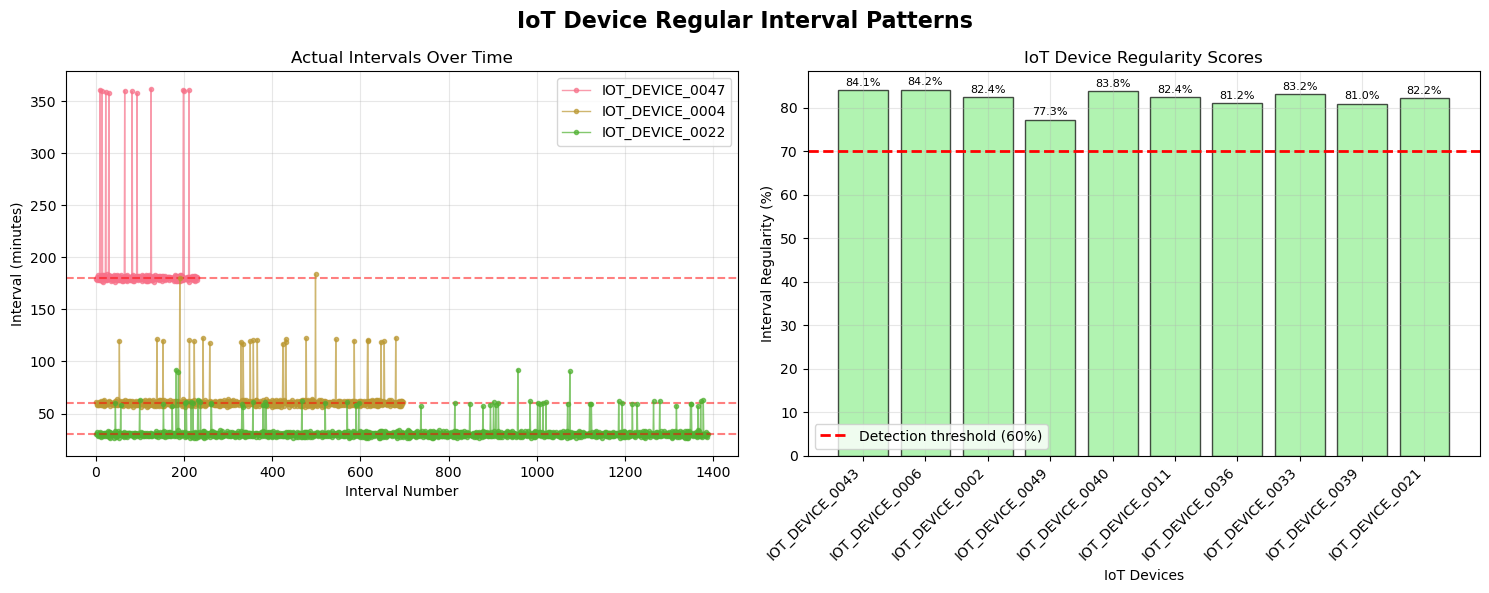

In [40]:
# IoT Device Interval Visualizations

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots - 2 plots in one row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('IoT Device Regular Interval Patterns', fontsize=16, fontweight='bold')

# Plot 1: Line plot showing actual intervals vs expected for each device
ax1 = axes[0]
for device_id in sample_devices[:3]:  # Show first 3 devices to avoid overcrowding
    device_intervals = intervals_df[intervals_df['device_id'] == device_id]
    if len(device_intervals) > 0:
        ax1.plot(device_intervals['interval_number'], device_intervals['actual_interval_minutes'],
                marker='o', markersize=3, linewidth=1, alpha=0.7, label=device_id)
        # Add expected interval line
        expected = device_intervals['expected_interval_minutes'].iloc[0]
        ax1.axhline(y=expected, color='red', linestyle='--', alpha=0.5)

ax1.set_title('Actual Intervals Over Time')
ax1.set_xlabel('Interval Number')
ax1.set_ylabel('Interval (minutes)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Regularity score visualization
ax2 = axes[1]
regularity_data = detected_iot[['user_id', 'popular_interval_percentage']].head(10)
device_names = [uid for uid in regularity_data['user_id']]  # Use full generic device IDs
bars = ax2.bar(range(len(regularity_data)), regularity_data['popular_interval_percentage'],
               color='lightgreen', alpha=0.7, edgecolor='black')
ax2.axhline(y=70, color='red', linestyle='--', linewidth=2, label='Detection threshold (60%)')
ax2.set_title('IoT Device Regularity Scores')
ax2.set_xlabel('IoT Devices')
ax2.set_ylabel('Interval Regularity (%)')
ax2.set_xticks(range(len(regularity_data)))
ax2.set_xticklabels(device_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, regularity_data['popular_interval_percentage']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Let's look at one random human user and one randomly selected IoT device.

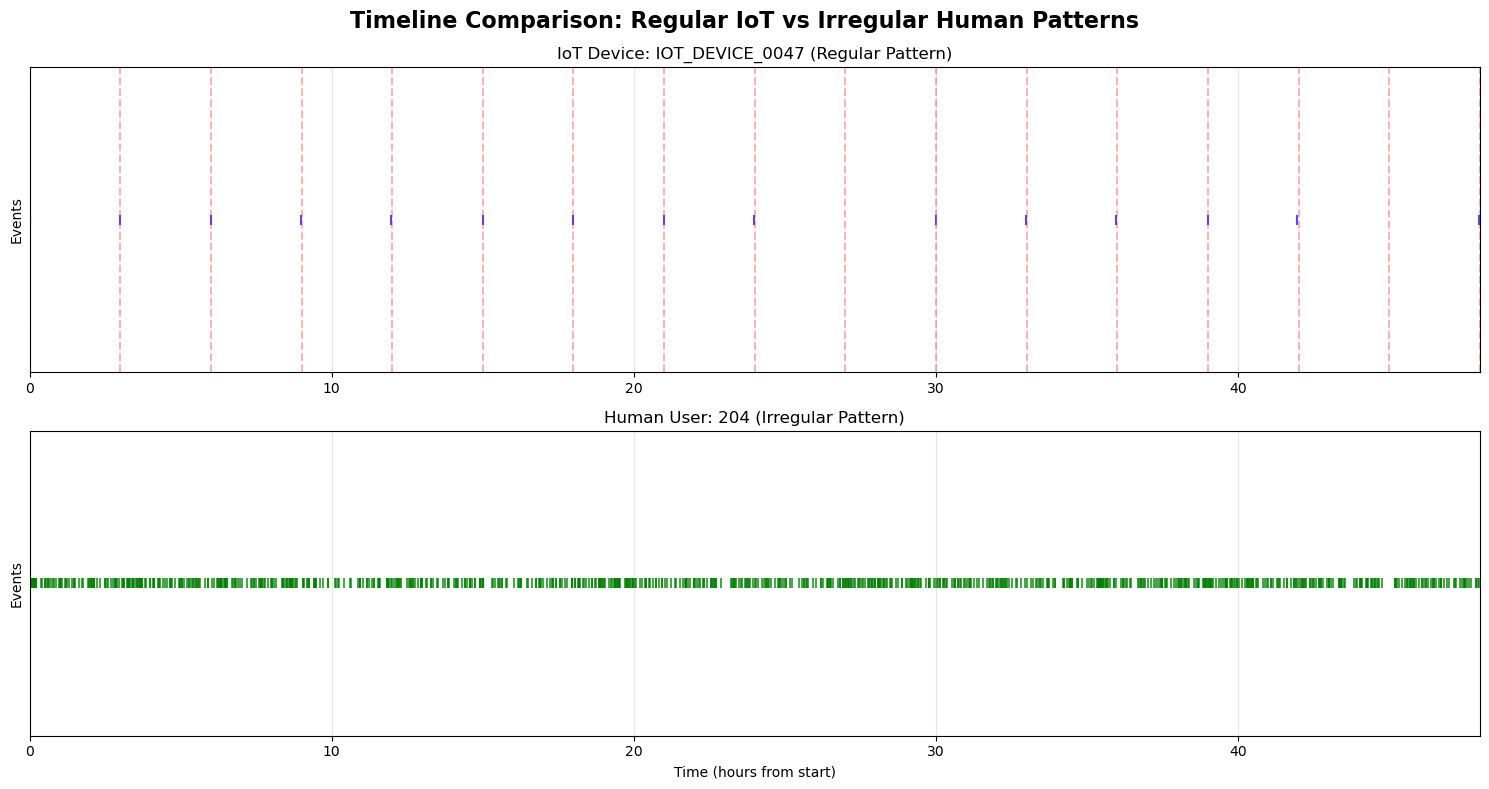

In [41]:
# Select one IoT device and one human user for comparison
sample_iot_device = sample_devices[0]  # First IoT device
sample_human_user = events_cleaned[
    (~events_cleaned['user_id'].str.contains('IOT_', na=False)) &
    (events_cleaned['user_id'].notna())
]['user_id'].value_counts().head(1).index[0]  # Most active human user

# Get data for both
iot_timeline = events_cleaned[events_cleaned['user_id'] == sample_iot_device].sort_values('timestamp')
human_timeline = events_cleaned[events_cleaned['user_id'] == sample_human_user].sort_values('timestamp')

# Convert timestamps to datetime for timeline analysis
iot_timeline = iot_timeline.copy()
iot_timeline['timestamp'] = pd.to_datetime(iot_timeline['timestamp'], format='mixed', errors='coerce')
human_timeline = human_timeline.copy()
human_timeline['timestamp'] = pd.to_datetime(human_timeline['timestamp'], format='mixed', errors='coerce')

# Create timeline plot
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Timeline Comparison: Regular IoT vs Irregular Human Patterns', fontsize=16, fontweight='bold')

# IoT device timeline (first 48 hours for clarity)
start_time = iot_timeline['timestamp'].min()
end_time = start_time + pd.Timedelta(hours=48)
iot_48h = iot_timeline[(iot_timeline['timestamp'] >= start_time) & (iot_timeline['timestamp'] <= end_time)]

ax1 = axes[0]
if len(iot_48h) > 0:
    # Create timeline with markers
    timeline_hours = [(ts - start_time).total_seconds() / 3600 for ts in iot_48h['timestamp']]
    ax1.scatter(timeline_hours, [1] * len(timeline_hours), alpha=0.7, s=50, color='blue', marker='|')

    # Get expected interval from detection results for this device
    device_info = detected_iot[detected_iot['user_id'] == sample_iot_device].iloc[0]
    expected_interval_minutes = device_info['most_popular_interval_minutes']
    expected_interval_hours = expected_interval_minutes / 60.0

    # Add vertical lines for expected intervals
    for hour in np.arange(0, 49, expected_interval_hours):
        ax1.axvline(x=hour, color='red', linestyle='--', alpha=0.3)

ax1.set_title(f'IoT Device: {sample_iot_device} (Regular Pattern)')
ax1.set_ylabel('Events')
ax1.set_xlim(0, 48)
ax1.set_ylim(0.5, 1.5)
ax1.grid(True, alpha=0.3)
ax1.set_yticks([])

# Human user timeline (same 48 hour period)
human_48h = human_timeline[(human_timeline['timestamp'] >= start_time) & (human_timeline['timestamp'] <= end_time)]

ax2 = axes[1]
if len(human_48h) > 0:
    timeline_hours = [(ts - start_time).total_seconds() / 3600 for ts in human_48h['timestamp']]
    ax2.scatter(timeline_hours, [1] * len(timeline_hours), alpha=0.7, s=50, color='green', marker='|')

ax2.set_title(f'Human User: {sample_human_user} (Irregular Pattern)')
ax2.set_xlabel('Time (hours from start)')
ax2.set_ylabel('Events')
ax2.set_xlim(0, 48)
ax2.set_ylim(0.5, 1.5)
ax2.grid(True, alpha=0.3)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

The comparison highlights clear interval regularity for the IoT device versus an irregular, human-like timing pattern.

## Exercise 3

Based on IoT behavior patterns, propose and explain one additional contextual filter to detect IoT devices in mobile phone data.

1. Activity pattern differences: How would you expect IoT devices to differ from human users in terms of:
   - Temporal patterns (time of day, day of week, seasonality)
   - Mobility patterns (movement speed, trajectory consistency, location types)

2. Filter proposal: Describe the additional filter you would implement based on these differences.

3. Implementation approach:
   - Which data signals will you analyze?
   - What thresholds or criteria will you use?
   - How will you distinguish IoT devices from human users?

Think creatively about what makes IoT devices fundamentally different from human mobile phone usage patterns.